# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'
data_dir="E:\DL_training_datas\celeba"

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

  Using cached https://files.pythonhosted.org/packages/f5/f0/9da3ef24ea7eb0ccd12430a261b66eca36b924aeef06e17147f9f9d7d310/matplotlib-2.0.2.tar.gz
    Complete output from command python setup.py egg_info:
    Edit setup.cfg to change the build options
    
    BUILDING MATPLOTLIB
                matplotlib: yes [2.0.2]
                    python: yes [3.7.3 (default, Mar 27 2019, 17:13:21) [MSC
                            v.1915 64 bit (AMD64)]]
                  platform: yes [win32]
    
    REQUIRED DEPENDENCIES AND EXTENSIONS
                     numpy: yes [version 1.16.2]
                       six: yes [using six version 1.12.0]
                  dateutil: yes [using dateutil version 2.8.0]
               functools32: yes [Not required]
              subprocess32: yes [Not required]
                      pytz: yes [using pytz version 2018.9]
                    cycler: yes [using cycler version 0.10.0]
                   tornado: yes [using tornado version 6.0.2]
               

Command "python setup.py egg_info" failed with error code 1 in C:\Users\纯\AppData\Local\Temp\pip-install-iv5wpk5x\matplotlib\


Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

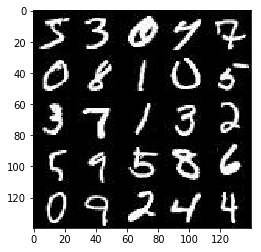

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

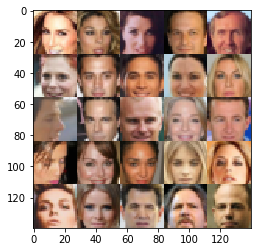

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width,image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

W0926 19:28:13.216148 15956 deprecation_wrapper.py:119] From E:\SDC_Pros\DeepLearning\04_face-generation\problem_unittests.py:20: The name tf.assert_rank is deprecated. Please use tf.compat.v1.assert_rank instead.



Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha *x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha *x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha *x3, x3)
        
        flat = tf.reshape(x3, (-1,7*7*256))
        logits = tf.layers.dense(flat, 1)
     
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha *x1, x1)#leaky relu
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha *x2, x2)
     
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha *x3, x3)
      
#         x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
#         x4 = tf.layers.batch_normalization(x4, training=is_train)
#         x4 = tf.maximum(alpha *x4, x4)
    
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

W0926 19:31:11.331158 15956 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

W0926 19:31:49.689872 15956 deprecation_wrapper.py:119] From E:\SDC_Pros\DeepLearning\04_face-generation\problem_unittests.py:46: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, losses = [], []
    steps = 0    
#     out_channel_dim = 3 if(data_image_mode == "RGB") else 1
    
#     input_real, batch_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images,lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    gen_samples = sess.run(generator(input_z,data_shape[3], is_train=False),
                                          feed_dict={input_z:batch_z})
                    samples.append(gen_samples)
#                     _ = view_s
                    show_generator_output(sess,25,input_z, data_shape[3], data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')   
        
        return losses, samples  
        
                              
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.6873... Generator Loss: 1.4861...
Epoch 1/2... Discriminator Loss: 0.0741... Generator Loss: 2.9470...
Epoch 1/2... Discriminator Loss: 0.1510... Generator Loss: 2.5682...
Epoch 1/2... Discriminator Loss: 0.1209... Generator Loss: 2.4705...
Epoch 1/2... Discriminator Loss: 0.0304... Generator Loss: 5.1845...
Epoch 1/2... Discriminator Loss: 0.1395... Generator Loss: 3.3406...
Epoch 1/2... Discriminator Loss: 0.0211... Generator Loss: 4.2391...
Epoch 1/2... Discriminator Loss: 0.0395... Generator Loss: 3.6965...
Epoch 1/2... Discriminator Loss: 0.1013... Generator Loss: 3.0968...
Epoch 1/2... Discriminator Loss: 0.1572... Generator Loss: 3.2617...


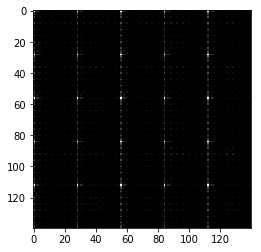

Epoch 1/2... Discriminator Loss: 0.0446... Generator Loss: 5.2852...
Epoch 1/2... Discriminator Loss: 0.2870... Generator Loss: 4.0959...
Epoch 1/2... Discriminator Loss: 0.0954... Generator Loss: 4.1122...
Epoch 1/2... Discriminator Loss: 0.1453... Generator Loss: 4.3103...
Epoch 1/2... Discriminator Loss: 0.0652... Generator Loss: 4.9146...
Epoch 1/2... Discriminator Loss: 0.1311... Generator Loss: 5.7224...
Epoch 1/2... Discriminator Loss: 0.0640... Generator Loss: 4.5584...
Epoch 1/2... Discriminator Loss: 0.1662... Generator Loss: 3.3340...
Epoch 1/2... Discriminator Loss: 0.1514... Generator Loss: 3.8077...
Epoch 1/2... Discriminator Loss: 0.0501... Generator Loss: 5.3513...


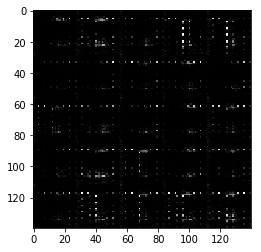

Epoch 1/2... Discriminator Loss: 0.0326... Generator Loss: 5.1183...
Epoch 1/2... Discriminator Loss: 0.0178... Generator Loss: 5.3882...
Epoch 1/2... Discriminator Loss: 0.0433... Generator Loss: 5.2217...
Epoch 1/2... Discriminator Loss: 0.1810... Generator Loss: 4.4022...
Epoch 1/2... Discriminator Loss: 0.0511... Generator Loss: 5.1490...
Epoch 1/2... Discriminator Loss: 0.0358... Generator Loss: 5.9669...
Epoch 1/2... Discriminator Loss: 0.0270... Generator Loss: 7.7405...
Epoch 1/2... Discriminator Loss: 0.0202... Generator Loss: 7.3636...
Epoch 1/2... Discriminator Loss: 0.0255... Generator Loss: 4.7135...
Epoch 1/2... Discriminator Loss: 0.0481... Generator Loss: 5.4749...


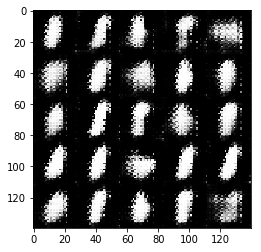

Epoch 1/2... Discriminator Loss: 0.0597... Generator Loss: 5.7696...
Epoch 1/2... Discriminator Loss: 0.0080... Generator Loss: 6.2208...
Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 6.5633...
Epoch 1/2... Discriminator Loss: 0.0200... Generator Loss: 5.0624...
Epoch 1/2... Discriminator Loss: 0.0053... Generator Loss: 6.0508...
Epoch 1/2... Discriminator Loss: 0.0300... Generator Loss: 5.3773...
Epoch 1/2... Discriminator Loss: 0.0219... Generator Loss: 7.7407...
Epoch 1/2... Discriminator Loss: 0.0451... Generator Loss: 4.9791...
Epoch 1/2... Discriminator Loss: 0.0236... Generator Loss: 5.6581...
Epoch 1/2... Discriminator Loss: 0.0901... Generator Loss: 5.8417...


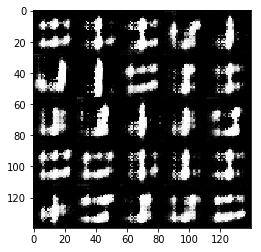

Epoch 1/2... Discriminator Loss: 0.0157... Generator Loss: 6.1557...
Epoch 1/2... Discriminator Loss: 0.0348... Generator Loss: 5.6514...
Epoch 1/2... Discriminator Loss: 0.3232... Generator Loss: 3.2210...
Epoch 1/2... Discriminator Loss: 0.2582... Generator Loss: 4.6279...
Epoch 1/2... Discriminator Loss: 0.1924... Generator Loss: 5.2816...
Epoch 1/2... Discriminator Loss: 0.2038... Generator Loss: 5.4425...
Epoch 2/2... Discriminator Loss: 0.1330... Generator Loss: 4.5366...
Epoch 2/2... Discriminator Loss: 0.0876... Generator Loss: 4.3784...
Epoch 2/2... Discriminator Loss: 0.0534... Generator Loss: 4.1690...
Epoch 2/2... Discriminator Loss: 0.1057... Generator Loss: 5.9432...


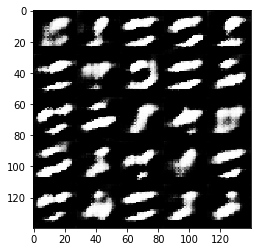

Epoch 2/2... Discriminator Loss: 0.1577... Generator Loss: 10.7231...


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 3.1615... Generator Loss: 1.3107...
Epoch 1/1... Discriminator Loss: 2.1522... Generator Loss: 1.3332...
Epoch 1/1... Discriminator Loss: 2.0777... Generator Loss: 1.7104...
Epoch 1/1... Discriminator Loss: 1.9237... Generator Loss: 2.4098...
Epoch 1/1... Discriminator Loss: 1.8937... Generator Loss: 2.0448...
Epoch 1/1... Discriminator Loss: 1.9791... Generator Loss: 3.2034...
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 3.5758...
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 2.4950...
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 1.7442...
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 2.1665...


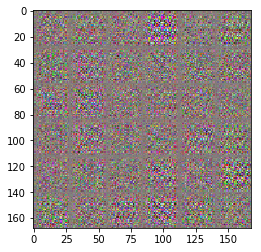

Epoch 1/1... Discriminator Loss: 0.4288... Generator Loss: 2.8696...
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.5800...
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.6080...
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 1.7431...
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 1.8374...
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 1.8222...
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.5738...
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.6810...
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 2.1632...
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 2.1483...


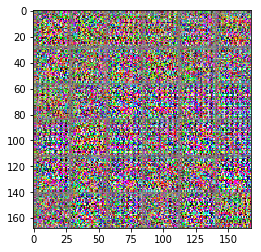

Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.9806...
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 2.6403...
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 2.6338...
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 1.9580...
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.6052...
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 2.0303...
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 2.1522...
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 3.4097...
Epoch 1/1... Discriminator Loss: 0.2547... Generator Loss: 2.9432...
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 2.8964...


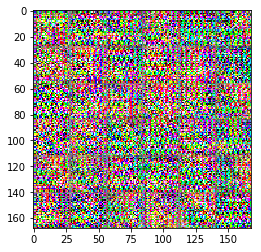

Epoch 1/1... Discriminator Loss: 0.1397... Generator Loss: 3.2280...
Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 3.1411...
Epoch 1/1... Discriminator Loss: 0.1751... Generator Loss: 2.8929...
Epoch 1/1... Discriminator Loss: 0.3143... Generator Loss: 2.1989...
Epoch 1/1... Discriminator Loss: 0.2191... Generator Loss: 2.6588...
Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 3.4353...
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 3.3142...
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 2.1424...
Epoch 1/1... Discriminator Loss: 0.2842... Generator Loss: 2.4216...
Epoch 1/1... Discriminator Loss: 0.1583... Generator Loss: 3.1052...


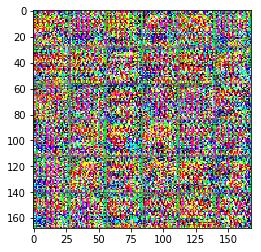

Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 3.6220...
Epoch 1/1... Discriminator Loss: 0.2534... Generator Loss: 3.3467...
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 3.2080...
Epoch 1/1... Discriminator Loss: 0.2259... Generator Loss: 3.0277...
Epoch 1/1... Discriminator Loss: 0.3032... Generator Loss: 2.8880...
Epoch 1/1... Discriminator Loss: 0.2398... Generator Loss: 3.9969...
Epoch 1/1... Discriminator Loss: 0.1354... Generator Loss: 4.2027...
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 3.5996...
Epoch 1/1... Discriminator Loss: 0.2408... Generator Loss: 3.8219...
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 3.5889...


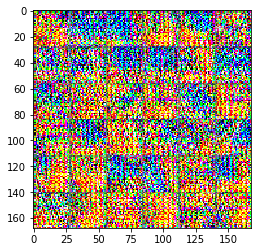

Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 3.3859...
Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 4.1654...
Epoch 1/1... Discriminator Loss: 0.2984... Generator Loss: 2.8305...
Epoch 1/1... Discriminator Loss: 0.1829... Generator Loss: 3.8684...
Epoch 1/1... Discriminator Loss: 0.0794... Generator Loss: 5.2377...
Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 5.5166...
Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 5.2228...
Epoch 1/1... Discriminator Loss: 0.1551... Generator Loss: 5.0294...
Epoch 1/1... Discriminator Loss: 0.1075... Generator Loss: 5.8904...
Epoch 1/1... Discriminator Loss: 0.2962... Generator Loss: 3.0316...


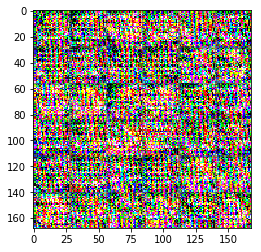

Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 3.1725...
Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 4.8618...
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 5.8378...
Epoch 1/1... Discriminator Loss: 0.0221... Generator Loss: 4.7460...
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 4.1842...
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 4.2768...
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 4.9458...
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 5.0917...
Epoch 1/1... Discriminator Loss: 0.0611... Generator Loss: 4.6099...
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 4.2450...


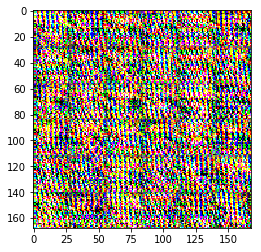

Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 2.5928...
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 3.8592...
Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 4.3793...
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 4.9930...
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.6550...
Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 5.5861...
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 5.4081...
Epoch 1/1... Discriminator Loss: 0.0766... Generator Loss: 4.0610...
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 4.8936...
Epoch 1/1... Discriminator Loss: 0.1062... Generator Loss: 3.5298...


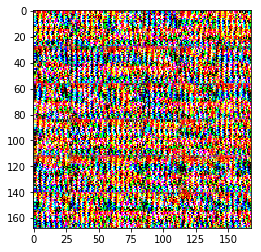

Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 3.4514...
Epoch 1/1... Discriminator Loss: 0.0181... Generator Loss: 5.2420...
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 6.7438...
Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.8454...
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 5.5551...
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 5.6973...
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 5.7194...
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 5.6943...
Epoch 1/1... Discriminator Loss: 0.0105... Generator Loss: 5.7537...
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 5.7231...


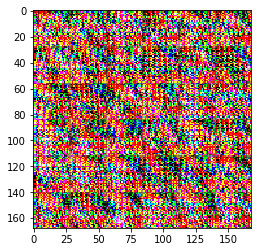

Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 5.0017...
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.3199...
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 4.3498...
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 5.0952...
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 5.7990...
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 5.7958...
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 5.7953...
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 5.7985...
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 5.2934...
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 4.7400...


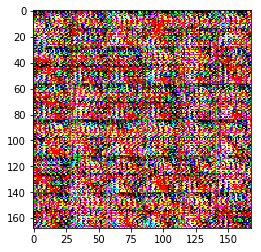

Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 3.9951...
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 4.9683...
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 5.6921...
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 5.7973...
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 5.7119...
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 5.2119...
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 4.3053...
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 3.9148...
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 4.7420...
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.0455...


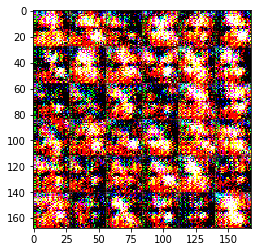

Epoch 1/1... Discriminator Loss: 0.0460... Generator Loss: 4.5042...
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 3.9838...
Epoch 1/1... Discriminator Loss: 0.1311... Generator Loss: 3.6261...
Epoch 1/1... Discriminator Loss: 0.1021... Generator Loss: 4.0763...
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 5.0067...
Epoch 1/1... Discriminator Loss: 0.0620... Generator Loss: 3.3556...
Epoch 1/1... Discriminator Loss: 0.0584... Generator Loss: 3.5566...
Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 3.8331...
Epoch 1/1... Discriminator Loss: 0.0182... Generator Loss: 4.8275...
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 4.0563...


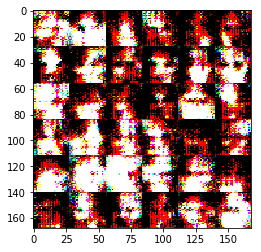

Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 4.9969...
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 4.3879...
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 4.3593...
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 4.9800...
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 4.2191...
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 5.1101...
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 4.9454...
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 5.6181...
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 5.5306...
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 5.6125...


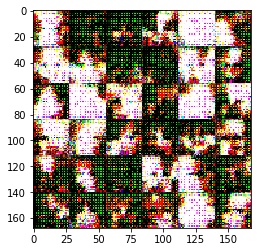

Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 5.3835...
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 5.2970...
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 5.3782...
Epoch 1/1... Discriminator Loss: 0.0079... Generator Loss: 5.4025...
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 5.7590...
Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 5.0503...
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 5.5307...
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 5.7108...
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 5.4702...
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 6.1679...


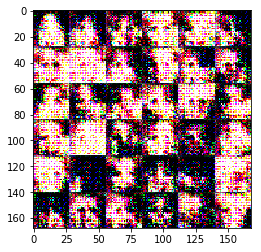

Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 6.1134...
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.1279...
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.2405...
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 6.4217...
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 5.5283...
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 5.7034...
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 5.3922...
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 5.4918...
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 5.9330...
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 5.9277...


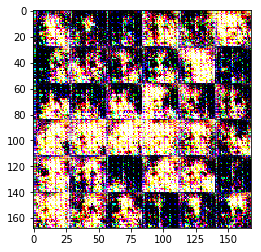

Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 5.7057...
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 5.7519...
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 5.8937...
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 6.1091...
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 5.4189...
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 5.9460...
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 5.8978...
Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 5.6322...
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.0041...
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 6.3307...


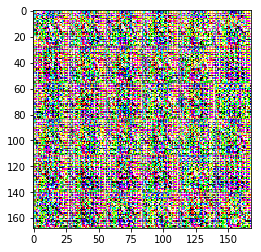

Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.6791...
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 6.3572...
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.4543...
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.5551...
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 6.3908...
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.4135...
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.4435...
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.5033...
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.7696...
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.6345...


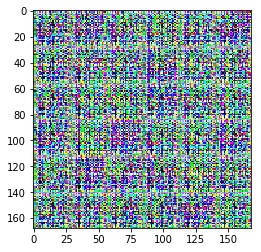

Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 6.8445...
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.8781...
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 6.9201...
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.8642...
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 6.6658...
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 6.6023...
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.0639...
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 7.1074...
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.5680...
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.2972...


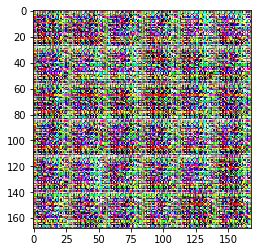

Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.2598...
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.1459...
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.2257...
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.1967...
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.0342...
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.8046...
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.3864...
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.1599...
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.6250...
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.0346...


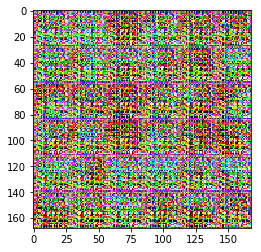

Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.8566...
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.1604...
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.2281...
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.8792...
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 6.3124...
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.9217...
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 7.4357...
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 5.9799...
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 5.9980...
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 6.2479...


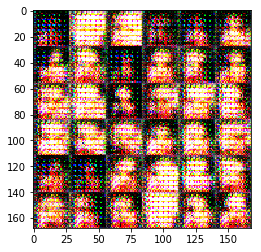

Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 6.3930...
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 6.4100...
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 8.2059...
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.8278...
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 7.5575...
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 7.1491...
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 5.6474...
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.4638...
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.3088...
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 7.1920...


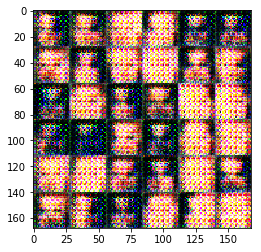

Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.8046...
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.8660...
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.0893...
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.9763...
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 6.2035...
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 7.1201...
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.2119...
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 5.6741...
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 7.3524...
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.5662...


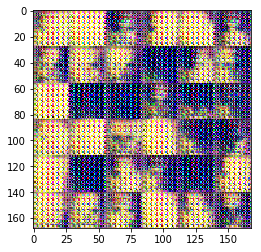

Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.6732...
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.5080...
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.9831...
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.4490...
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.5485...
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.0498...
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.5956...
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.4055...
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 7.3770...
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.8275...


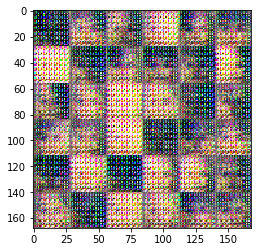

Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 6.7374...
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.3938...
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 6.3677...
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 6.2029...
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.1175...
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 7.9362...
Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 6.1434...
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 12.5103...
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 10.9608...
Epoch 1/1... Discriminator Loss: 0.1265... Generator Loss: 3.8593...


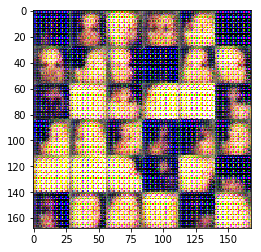

Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 6.6148...
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 7.8331...
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 6.1578...
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 4.8769...
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 5.0416...
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 8.5235...


KeyboardInterrupt: 

In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。